# Modelling Tracking Data for Albatross

In [1]:
import jax.numpy as jnp
from jax import Array
from jax import vmap, jit

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import pandas as pd

import pickle

import os

from abc import ABC

from load_manifold import load_albatross_metrics, load_albatross_data

from plotting import TackPlots
from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, T2, RiemannianNavigation, nEuclidean
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

In [2]:
figure_path = '../figures/albatross_tacking_estimation/'

In [3]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [6]:
data_path = 'tacking_gpu/albatross/'
method = 'adam' #constant, adam, bfgs
curve_name = 'poincarre_north' #'direction_only/' #'time_only/' #'poincarre/'
T = 1_000
N_sim = 5

In [7]:
Plots = TackPlots(font_size=25,
                  power_lim=-2.,
                  colors=['red', 'blue'],
                  linewidth = 2.5,
                  s = 500,
                  alpha = 1.0,
                 )

In [8]:
x_data, time_data, x1, x2, w1, w2, w_data, data_idx = load_albatross_data()

In [9]:
z0 = [{key1: [vals2[0] for vals2 in vals]} for key1,vals in data_idx.items()]
zT = [{key1: [vals2[1] for vals2 in vals]} for key1,vals in data_idx.items()]

xplots = [x_data[key] for key, vals in data_idx.items()]

In [10]:
bird_idx = list(data_idx.keys())

## Loading Data

In [11]:
albatross_data = pd.read_excel('../../../../Data/albatross/tracking_data.xls')

In [12]:
albatross_data

,ID,SPP_ID,SPP,DTYPE,SEX,RING,TRACKID,POINTID,STAGE,PRP_TRP,...,DIST_5_KM,STR_4,STR_5,FLT_DIR_2,FLT_DIR_5,RAW_SPD_2_MS,REL_FLT_DIR_2_HRS,REL_FLT_DIR_2_DAY,REL_FLT_DIR_2_WK,REL_FLT_DIR_2_MNTH
0,1,1,LMSA,PTT,U,2875660,1842-43,1,P,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,LMSA,PTT,U,2875660,1842-43,2,P,0.000180,...,NaN,NaN,NaN,250.015463,NaN,43.394440,144.015463,56.748982,148.326094,124.060130
2,3,3,LMSA,PTT,U,2875660,1842-43,3,P,0.000711,...,47.655794,0.553709,NaN,124.294351,216.042880,6.478954,14.394351,68.972130,22.604981,1.660983
3,4,4,LMSA,PTT,U,2875660,1842-43,4,P,0.003945,...,39.801064,0.633084,0.539971,227.794938,211.492234,9.910928,127.294938,31.621182,125.137970,109.162783
4,5,5,LMSA,PTT,U,2875660,1842-43,5,P,0.005027,...,38.431004,0.154711,0.596624,103.360732,217.727708,7.455013,7.139268,89.905749,1.671363,22.594601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49559,49560,642,WAN,PTT,F,5092135,9294-6,37,B,0.861469,...,142.485158,0.363267,0.608613,134.551469,120.187617,8.242840,75.651469,NaN,NaN,NaN
49560,49561,643,WAN,PTT,F,5092135,9294-6,38,B,0.902139,...,97.221054,0.596972,0.465129,47.553003,87.785329,2.278346,16.046997,NaN,NaN,NaN
49561,49562,644,WAN,PTT,F,5092135,9294-6,39,B,0.928798,...,80.776590,0.606222,0.616669,66.226985,61.298995,0.238079,2.726985,NaN,NaN,NaN
49562,49563,645,WAN,PTT,F,5092135,9294-6,40,B,0.963683,...,NaN,NaN,NaN,66.701806,NaN,3.285985,24.398194,NaN,NaN,NaN


In [13]:
save_path = ''.join((data_path, curve_name, '/'))    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [14]:
onlyfiles

['adam_poincarre_north_bird_2_data_2.pkl',
 'adam_poincarre_north_bird_1_data_1.pkl',
 'adam_poincarre_north_bird_2_data_0.pkl',
 'adam_poincarre_north_bird_0_data_1.pkl',
 'adam_poincarre_north_bird_1_data_2.pkl',
 'adam_poincarre_north_bird_2_data_1.pkl',
 'adam_poincarre_north_bird_0_data_2.pkl',
 'adam_poincarre_north_bird_0_data_0.pkl',
 'adam_poincarre_north_bird_1_data_0.pkl']

In [15]:
estimates = {}
for bidx in range(3):
    inner_estimates = {}
    for didx in range(3):
        file_path = os.path.join(save_path, f"{method}_{curve_name}_bird_{bidx}_data_{didx}.pkl")
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        inner_estimates[didx] = values
    estimates[bird_idx[bidx]] = inner_estimates

In [16]:
for k1,v1 in estimates.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():
            print(f"Bird {k1} data {k2} geodesic {k3}: \t\t Travel time = {v3['travel_time']}")

Bird 0 data 0 geodesic Geodesic: 		 Travel time = 1.4220563485542865
Bird 0 data 0 geodesic ReverseGeodesic: 		 Travel time = 4.162995378223812
Bird 0 data 0 geodesic Tacking: 		 Travel time = 1.4226957674625285
Bird 0 data 0 geodesic ReverseTacking: 		 Travel time = 1.4235025797903478
Bird 0 data 0 geodesic ExpectedGeodesic: 		 Travel time = 1.4220563485542865
Bird 0 data 0 geodesic ExpectedReverseGeodesic: 		 Travel time = 4.162995378223812
Bird 0 data 0 geodesic ExpectedTacking: 		 Travel time = 1.4226957674625285
Bird 0 data 0 geodesic ExpectedReverseTacking: 		 Travel time = 1.4235025797903478
Bird 0 data 0 geodesic Geodesic0: 		 Travel time = 1.4220563485542865
Bird 0 data 0 geodesic ReverseGeodesic0: 		 Travel time = 4.162995378223812
Bird 0 data 0 geodesic Tacking0_1: 		 Travel time = 1.4226957674625285
Bird 0 data 0 geodesic ReverseTacking0_1: 		 Travel time = 1.4235025797903478
Bird 0 data 0 geodesic Geodesic1: 		 Travel time = 1.4220563485542865
Bird 0 data 0 geodesic Revers

## Plotting the Data

In [17]:
#Source: https://stackoverflow.com/questions/26911898/matplotlib-curve-with-arrow-ticks

def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
    arrowstyle='-|>', arrowsize=1, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes: 
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

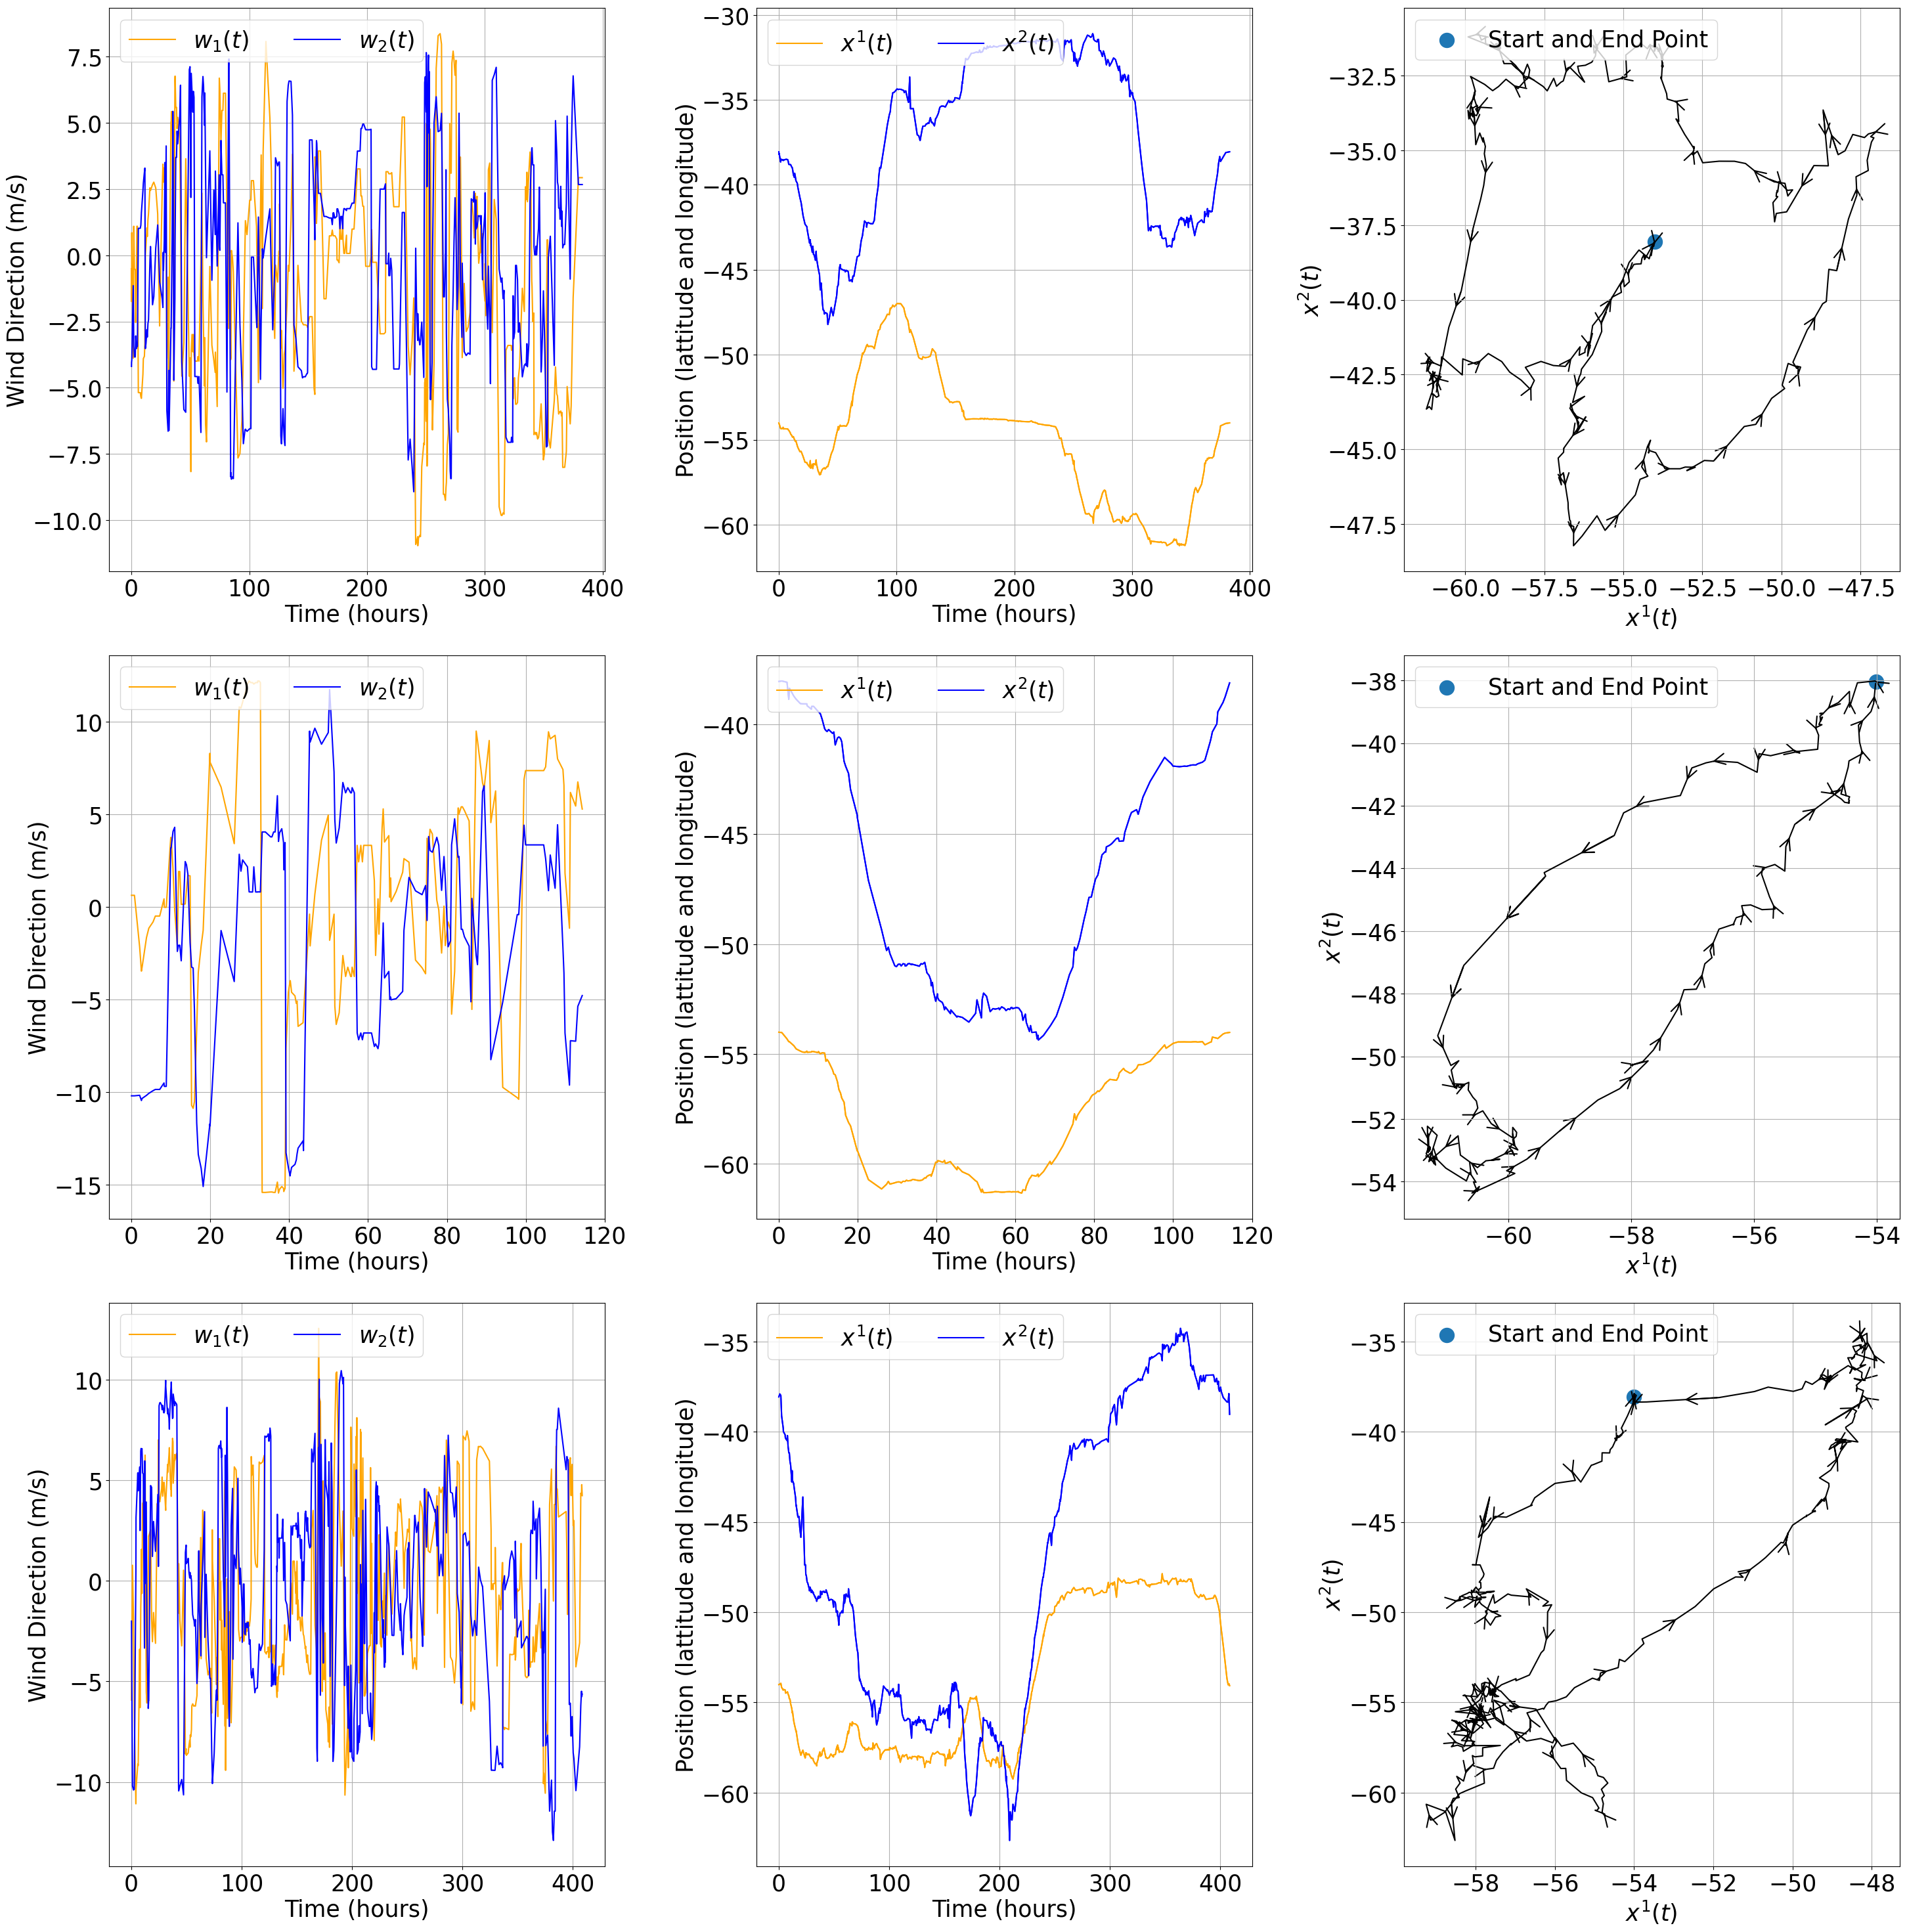

In [18]:
fig = plt.figure(figsize=(len(bird_idx)*10,len(bird_idx)*10))

for i in range(len(bird_idx)):
    
    idx = bird_idx[i]
    ax = fig.add_subplot(3,3,len(bird_idx)*i+1)
    ax.plot(time_data[idx], w1[idx], color='orange', label=f'$w_{1}(t)$')
    ax.plot(time_data[idx], w2[idx], color='blue', label=f'$w_{2}(t)$')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Wind Direction (m/s)')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

    ax = fig.add_subplot(3,3,len(bird_idx)*i+2)
    ax.plot(time_data[idx], x1[idx], color='orange')
    ax.plot(time_data[idx], x2[idx], color='blue')
    ax.plot(time_data[idx], x1[idx], color='orange', label=f'$x^{1}(t)$')
    ax.plot(time_data[idx], x2[idx], color='blue', label=f'$x^{2}(t)$')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Position (lattitude and longitude)')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

    ax = fig.add_subplot(3,3,len(bird_idx)*i+3)
    ax.scatter(x1[idx][0], x2[idx][0], s=250, label="Start and End Point")
    line, = ax.plot(x1[idx], x2[idx], 'k-')
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0., 1., 50),
                        arrowstyle='->', arrowsize=3)
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'bird_data.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Plotting the Indicatrix Field

In [19]:
v_min = 0.0
v_max = 20.0
v_mean= v_max/2
v_slope = 0.25

In [20]:
t0, z0, zT, Malpha, Mbeta, MEalpha, MEbeta, tack_metrics, reverse_tack_metrics = load_albatross_metrics(manifold=curve_name,
                                                                                                        idx_birds=0,
                                                                                                        idx_data=0,
                                                                                                       )

In [21]:
idx_val = 0

In [22]:
start_idx = data_idx[bird_idx[idx_val]][0][0]
end_idx = data_idx[bird_idx[idx_val]][0][1]

In [23]:
v_start = w_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][0]]
v_end = w_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][1]]
x_start = x_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][0]]
x_end = x_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][1]]

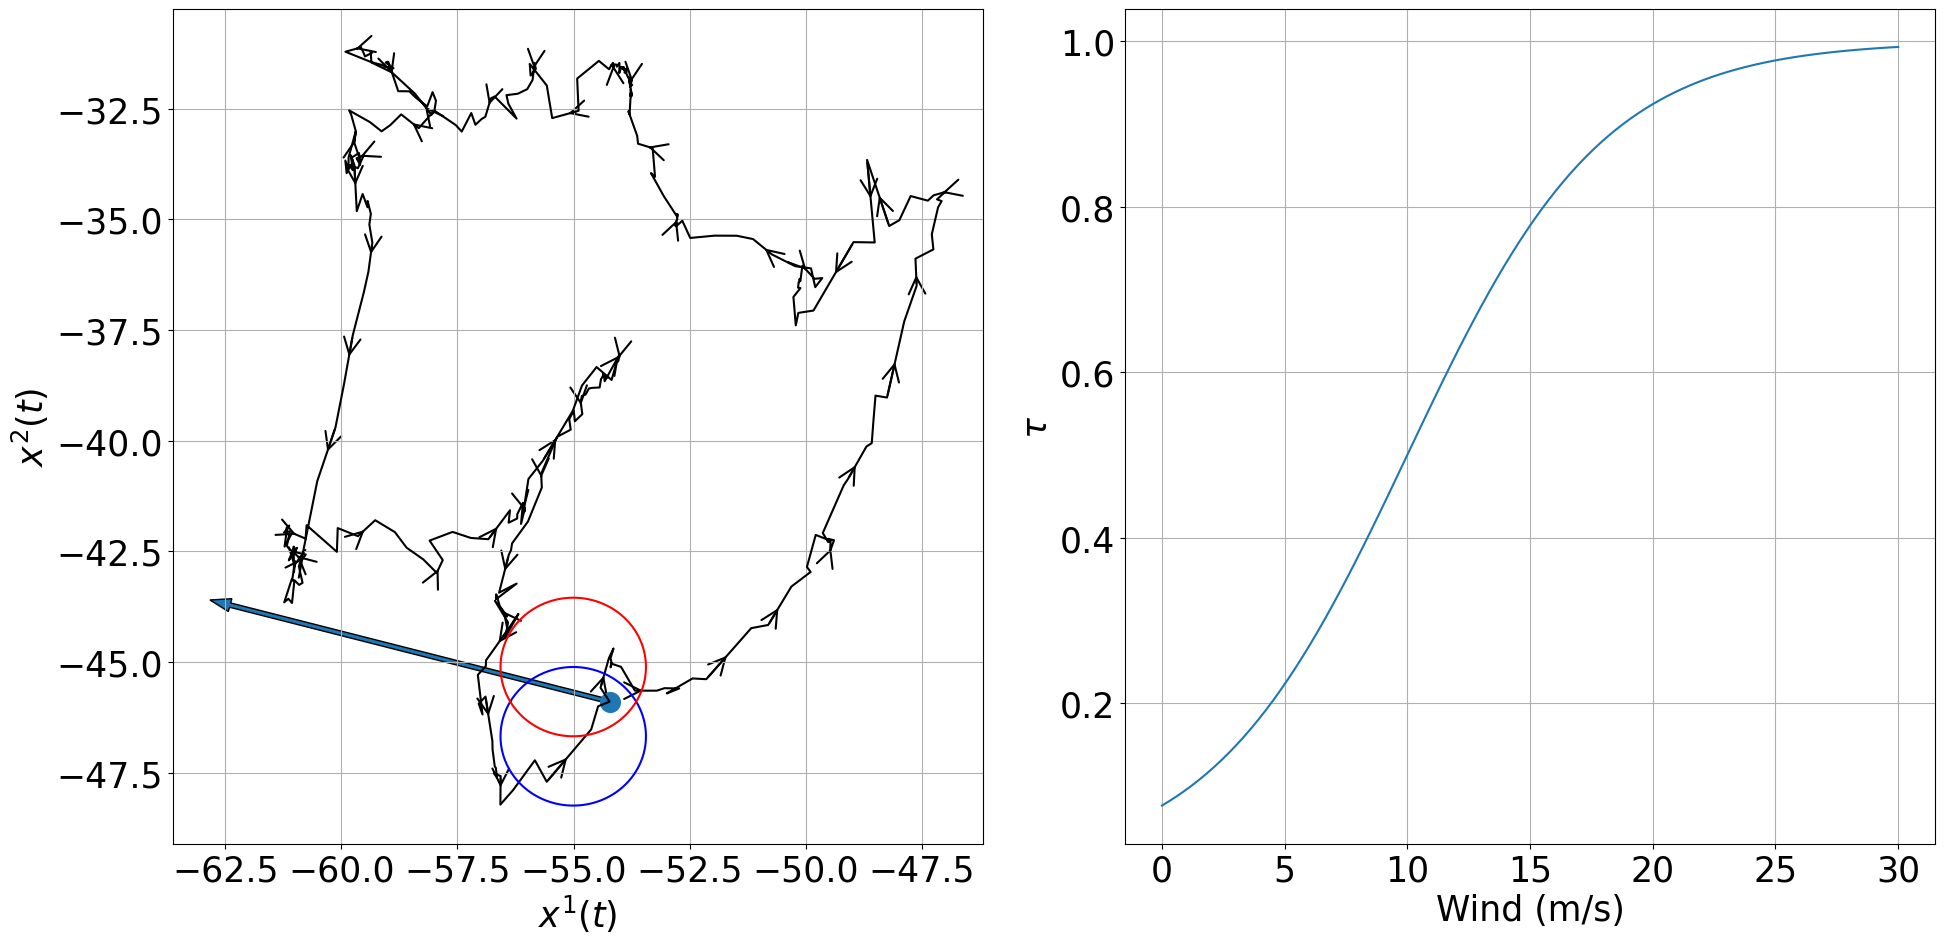

In [24]:
s_steps = [0.0, 1.0]
x_points = [x_start, x_end]
v_points = [v_start, v_end]

fig = plt.figure(figsize=(2*10,10))

ax = fig.add_subplot(1,2,1)
indicatrix_alpha = Malpha.indicatrix(0.0, x_points[0], N_points=100000)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = Mbeta.indicatrix(0.0, x_start, N_points=100000)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
line, = ax.plot(x1[bird_idx[idx_val]], x2[bird_idx[idx_val]], 'k-')
add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0., 1., 50),
                    arrowstyle='->', arrowsize=3)
ax.set_xlabel(f'$x^{1}(t)$')
ax.set_ylabel(f'$x^{2}(t)$')
ax.grid(True)
#ax.legend(loc="upper left", ncol=2)

ax.plot(x_points[0][0]+indicatrix_alpha[:,0], x_points[0][1]+indicatrix_alpha[:,1], color="blue")
ax.plot(x_points[0][0]+indicatrix_beta[:,0], x_points[0][1]+indicatrix_beta[:,1], color="red")
ax.arrow(x_points[0][0], x_points[0][1], v_points[0][0], v_points[0][1], width = 0.1)
ax.scatter(x_points[0][0],x_points[0][1], s=200)
    
wind_test = jnp.linspace(0.0,30.0,100)
tau = v_min/v_max+1.0/(1+jnp.exp(-v_slope*(wind_test-v_mean)))

ax = fig.add_subplot(122)
ax.plot(wind_test, tau)
ax.set_xlabel('Wind (m/s)')
ax.set_ylabel(r"$\tau$")
ax.grid(True)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'bird_metric.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Estimated Curves

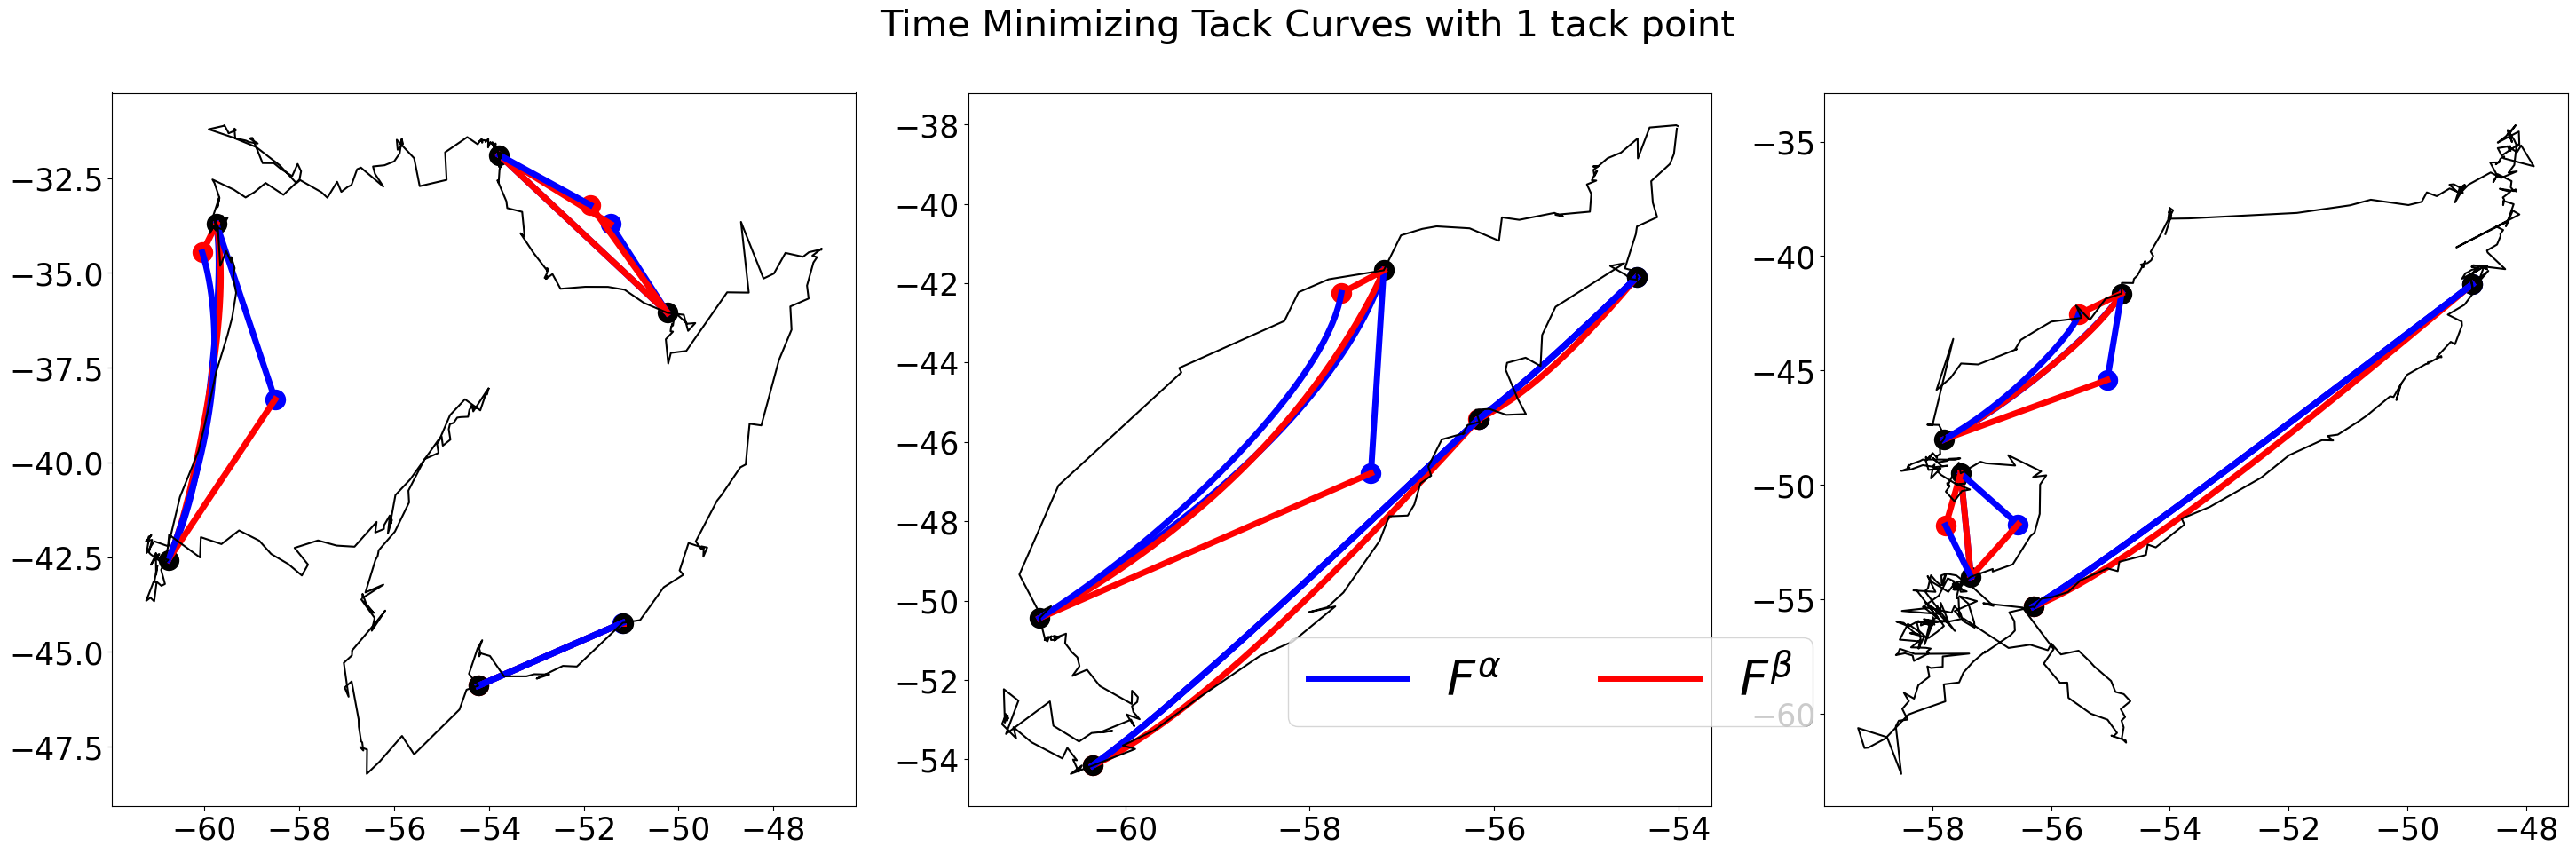

In [25]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

i = 0
for bibidx in bird_idx:
    ax = fig.add_subplot(1,3,i+1)

    for j in range(3):

        curves = estimates[bibidx][j]
    
        #z0_point = z0[bibidx][j]
        #zT_point = zT[bibidx][j]
    
        zs = curves['Geodesic']['zs']
        zs_reverse = curves['ReverseGeodesic']['zs']
        tack_curve = curves['Tacking']['zs']
        reverse_tack_curve = curves['ReverseTacking']['zs']
        
        #stochastic_zs = jnp.stack([curves[f'Geodesic{i}']['zs'] for i in range(N_sim)])
        #stochastic_zs_reverse = jnp.stack([curves[f'ReverseGeodesic{i}']['zs'] for i in range(N_sim)])
        #stochastic_tack_curve = jnp.stack([curves[f'Tacking{i}_1']['zs'] for i in range(N_sim)])
        #stochastic_reverse_tack_curve = jnp.stack([curves[f'ReverseTacking{i}_1']['zs'] for i in range(N_sim)])
    
        ax.plot(zs[:,0], zs[:,1], color='blue', linewidth=5.)
        ax.plot(zs_reverse[:,0], zs_reverse[:,1], color='red', linewidth=5.)
        ax.plot(tack_curve[:T,0], tack_curve[:T,1], color='blue', linewidth=5.)
        ax.scatter(tack_curve[T,0], tack_curve[T,1], color='blue', s=250)
        ax.plot(tack_curve[T:,0], tack_curve[T:,1], color='red', linewidth=5.)
        ax.plot(reverse_tack_curve[:T,0], reverse_tack_curve[:T,1], color='red', linewidth=5.)
        ax.scatter(reverse_tack_curve[T,0], reverse_tack_curve[T,1], color='red', s=250)
        ax.plot(reverse_tack_curve[T:,0], reverse_tack_curve[T:,1], color='blue', linewidth=5.)

        ax.scatter(zs[0,0], zs[0,1], color='black', s=250)
        ax.scatter(zs[-1,0], zs[-1,1], color='black', s=250)

    ax.plot(x1[bibidx], x2[bibidx], 'k-')
    i += 1
    
plt.suptitle("Time Minimizing Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, f'albatross_curves_{curve_name}2.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

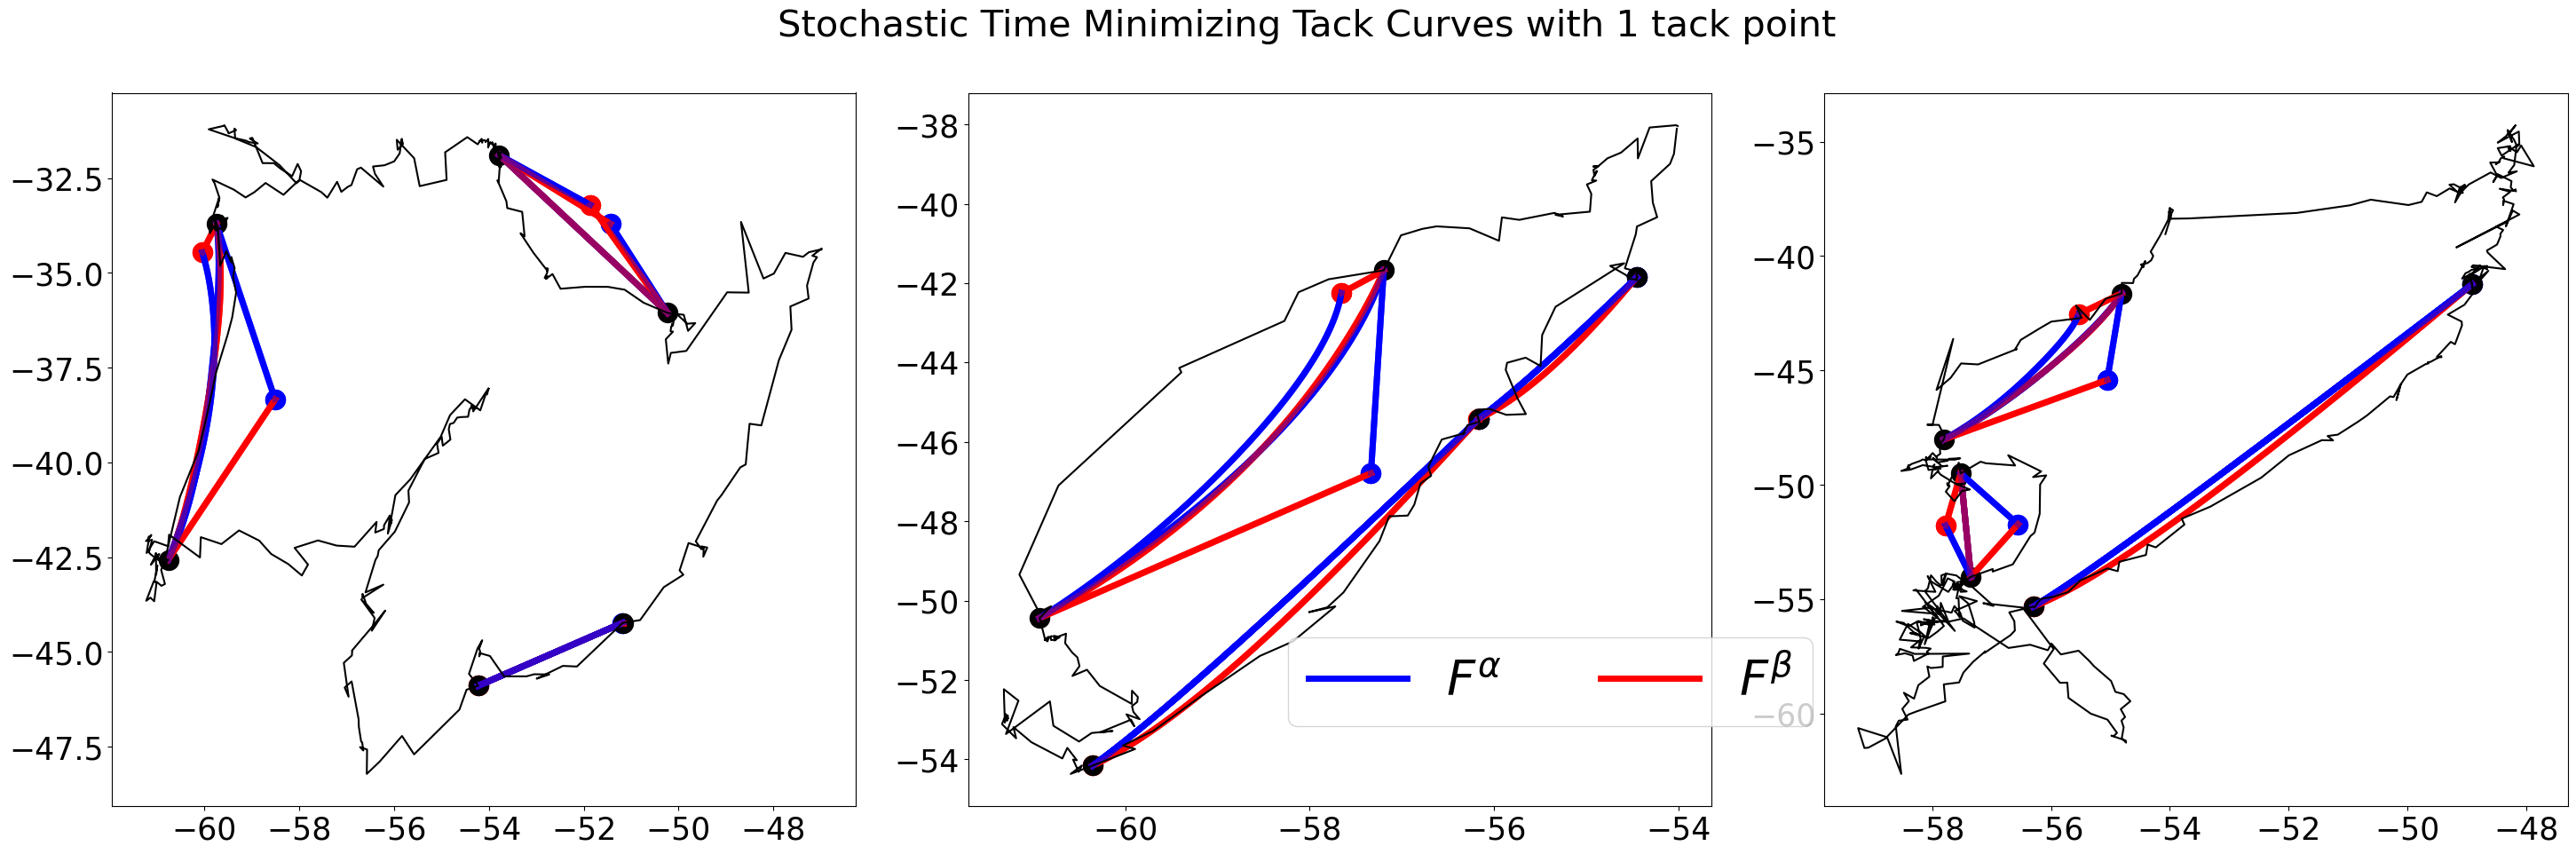

In [26]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

i = 0
for bibidx in bird_idx:
    ax = fig.add_subplot(1,3,i+1)

    for j in range(3):

        curves = estimates[bibidx][j]
    
        #z0_point = z0[bibidx][j]
        #zT_point = zT[bibidx][j]
    
        zs = curves['ExpectedGeodesic']['zs']
        zs_reverse = curves['ExpectedReverseGeodesic']['zs']
        tack_curve = curves['ExpectedTacking']['zs']
        reverse_tack_curve = curves['ExpectedReverseTacking']['zs']
        
        stochastic_zs = jnp.stack([curves[f'Geodesic{i}']['zs'] for i in range(N_sim)])
        stochastic_zs_reverse = jnp.stack([curves[f'ReverseGeodesic{i}']['zs'] for i in range(N_sim)])
        stochastic_tack_curve = jnp.stack([curves[f'Tacking{i}_1']['zs'] for i in range(N_sim)])
        stochastic_reverse_tack_curve = jnp.stack([curves[f'ReverseTacking{i}_1']['zs'] for i in range(N_sim)])

        T = 1_000
    
        ax.plot(zs[:,0], zs[:,1], color='blue', linewidth=5.)
        ax.plot(zs_reverse[:,0], zs_reverse[:,1], color='red', linewidth=5.)
        ax.plot(tack_curve[:T,0], tack_curve[:T,1], color='blue', linewidth=5.)
        ax.scatter(tack_curve[T,0], tack_curve[T,1], color='blue', s=250)
        ax.plot(tack_curve[T:,0], tack_curve[T:,1], color='red', linewidth=5.)
        ax.plot(reverse_tack_curve[:T,0], reverse_tack_curve[:T,1], color='red', linewidth=5.)
        ax.scatter(reverse_tack_curve[T,0], reverse_tack_curve[T,1], color='red', s=250)
        ax.plot(reverse_tack_curve[T:,0], reverse_tack_curve[T:,1], color='blue', linewidth=5.)

        for zs, zs_reverse, tack_curve, reverse_tack_curve in zip(stochastic_zs, stochastic_zs_reverse, stochastic_tack_curve, stochastic_reverse_tack_curve):
            ax.plot(zs[:,0], zs[:,1], color='blue', linewidth=5., alpha=0.2)
            ax.plot(zs_reverse[:,0], zs_reverse[:,1], color='red', linewidth=5., alpha=0.2)
            ax.plot(tack_curve[:T,0], tack_curve[:T,1], color='blue', linewidth=5., alpha=0.2)
            ax.scatter(tack_curve[T,0], tack_curve[T,1], color='blue', s=250, alpha=.2)
            ax.plot(tack_curve[T:,0], tack_curve[T:,1], color='red', linewidth=5., alpha=0.2)
            ax.plot(reverse_tack_curve[:T,0], reverse_tack_curve[:T,1], color='red', linewidth=5., alpha=0.2)
            ax.scatter(reverse_tack_curve[T,0], reverse_tack_curve[T,1], color='red', s=250, alpha=0.2)
            ax.plot(reverse_tack_curve[T:,0], reverse_tack_curve[T:,1], color='blue', linewidth=5., alpha=0.2)

        ax.scatter(zs[0,0], zs[0,1], color='black', s=250)
        ax.scatter(zs[-1,0], zs[-1,1], color='black', s=250)

    ax.plot(x1[bibidx], x2[bibidx], 'k-')
    i += 1
    
plt.suptitle("Stochastic Time Minimizing Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, f'albatross_stochastic_{curve_name}2.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    